<a href="https://colab.research.google.com/github/RasyaAkbar/learning-py-torch/blob/main/03.%20Binary%20and%20Multi-class%20classification%20%2B%20Exercise%20(Moon%20and%20Spiral).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import torch
from torch import nn # nn contains all of building blocks of neural networks from torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn # great for machine learning purposes
from sklearn.datasets import make_circles

In [128]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # put a bit of randomness
                    random_state=42 # equivalent of seed
                    )

len(X), X[:5], y[:5]

(1000,
 array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [129]:
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10) #print 10 first row

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


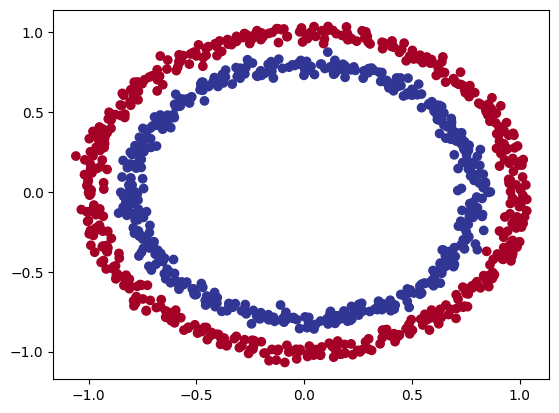

In [130]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu # cmap stands for colormap, RdYlBu stands for red, yellow, blue
            )

**Note**: the data we're working on is called toy dataset, small enough to experiment, but sizeable enough to learn fundamentals

## 1.1 Check input and output shapes

In [131]:
X.shape, y.shape

((1000, 2), (1000,))

In [132]:
# View the first example of features and labels

X[0], y[0], X[0].shape, y[0].shape

(array([0.75424625, 0.23148074]), 1, (2,), ())

## 1.2 Turn data into tensors and create train and test splits

In [133]:
type(X)

numpy.ndarray

In [134]:
# Turn data into tensors
# change from numpy float64 to tensor float32
X = torch.from_numpy(X).type(torch.float) # .float default into float32
y = torch.from_numpy(y).type(torch.float)

In [135]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [136]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% of data will be test & 80% will be train
                                                    random_state=42 # train_test_split split the data randomly, for reproducibility use random_state (seed)
                                                    )

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)
len(X_train), len(X_test), len(y_train), len(y_test), X_train.shape, X_train[:1], y_train[:5]

(800,
 200,
 800,
 200,
 torch.Size([800, 2]),
 tensor([[ 0.6579, -0.4651]]),
 tensor([1., 0., 0., 0., 1.]))

## 2. Building a model

We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing nn.Module.
3. Defining a loss function and optimizer.
4. Creating a training loop (this'll be in the next section).




### How about we create a model?

We'll want a model capable of handling our X data as inputs and producing something in the shape of our y data as ouputs.

In other words, given X (features) we want our model to predict y (label).

This setup where you have features and labels is referred to as supervised learning. Because your data is telling your model what the outputs should be given a certain input.

To create such a model it'll need to handle the input and output shapes of X and y.

Remember how I said input and output shapes are important? Here we'll see why.

Let's create a model class that:

1. Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
2. Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
3. Defines a forward() method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target device.

In [137]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # layer_1 input (X) will take the shape of 2 output will be passed on layer_2,
    # the reason why it got upscaled is bcuz our model have more opportunity to learn pattern, but it also has limit where the benefit start to wear off
    # for example if its only 2 features to learn pattern from -> we can give them 5 feature to learn pattern from

    self.layer_2 = nn.Linear(in_features=5, out_features=1) # layer_2 input will take the output of layer_1 and the output will be y with the shape of 1

    # 3. Defines a forward() method containing the forward pass computation of the model.
  def forward(self, x: torch.Tensor)-> torch.Tensor:
     return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiates the model class and sends it to the target device.
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [138]:
#  Model 0 can be simplified using nn.Sequential
model_0_seq = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), # layer_1 input (X) will take the shape of 2 output will be passed on layer_2,
    nn.Linear(in_features=5, out_features=1) # layer_2 input will take the output of layer_1 and the output will be y with the shape of 1
).to(device)

model_0_seq

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [139]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer_2.bias', tensor([-0.2060]))])

In [140]:
# Make Predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test)
len(untrained_preds), untrained_preds.shape, len(X_test), X_test.shape, untrained_preds[:10], y_test[:10], X_test[:10]

(200,
 torch.Size([200, 1]),
 200,
 torch.Size([200, 2]),
 tensor([[-0.1269],
         [-0.0967],
         [-0.1908],
         [-0.1089],
         [-0.1667],
         [-0.1484],
         [-0.0826],
         [-0.0946],
         [-0.1918],
         [-0.0944]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]))

## 2.1 Setup loss fuction and optimizer

For example, for a regression problem (predicting a number) you might used mean absolute error (MAE) loss.

And for a binary classification problem (like ours), you'll often use binary cross entropy as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, torch.optim.SGD()) can be used for a range of problems, and the same applies to the Adam optimizer (torch.optim.Adam()).

(Reference: https://www.learnpytorch.io/02_pytorch_classification/#2-building-a-model)

In [141]:
# setup loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = BCELoss with sigmoid activation function built-in, using BCELoss require to process input through sigmoid activation func manually

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01
                            )

quote from docs regarding `BCEWithLogitsLoss()`:
"This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability."

https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

In [142]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train Model

1. Forward propagation (also called forward pass)
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero gradient
4. Backpropagation (Loss backward)
5. Optimizer step (Gradient descent)

## 3.1 Going from raw logits -> prediction probabilities -> prediction labels

The raw outputs of our model are often referred to as logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function. (softmax for multiclass classification, sigmoid for binary classification)

Then we can convert our models prediction probabilities to **prediction labels** either rounding them or taking `argmax()`

In [143]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits= model_0(X_test)[:5]
y_logits # output logits which is raw form of output data before being passed into activation func

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]])

In [144]:
y_test[:5] # we want logits to the same format as this

tensor([1., 0., 1., 0., 1.])

In [145]:
# Use the sigmoid activation function to our model logits to turn them into predictions
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]])

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

* If `y_pred_probs` >= 0.5, `y=1` (class 1)
* If `y_pred_probs` < 0.5, `y=0` (class 0)

In [146]:
# Find the prediction label
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test)[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

### 3.2 Building training and test loop

In [147]:
torch.manual_seed(42) # optimizer step can be quite random depending on model prediction (y_pred)

# An epoch is one loop through the data (this is a hyperparameter)
epochs = 1000

# Track different values
epoch_count = []
loss_values = []
test_loss_values =[]


### Training (using training data)

#0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients


  #1. Forward propagation (also called forward pass)
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2. Calculate the loss / accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
  #                y_train)
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expect raw logits as inpur
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  #3. Optimizer zero gradient
  optimizer.zero_grad() # start fresh each iteration

  #4. Backpropagation (Loss backward)
  loss.backward()

  #5. Optimizer step (Gradient descent)
  # Optimizer step optimize the parameter so that we can reach the point of convergence (where loss = 0 (great prediction))
  optimizer.step() # by default how optimizer changes will accumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop
                  # may refer to the docs to understand why it accumulates

  ### Testing (using testing data)
  model_0.eval() # turns off different settings in the model not needing for testing
  with torch.inference_mode(): # turns off gradient tracking and couple more things behind the scenes
    #1. Forward propagation on test data
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #2. Calculate the test loss / Accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                    y_pred=test_pred)
  if epoch % 100 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc} | Test loss: {test_loss} | Test Accuracy: {test_acc}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.6956854462623596 | Accuracy: 50.0 | Test loss: 0.697385311126709 | Test Accuracy: 50.0
OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]])), ('layer_1.bias', tensor([0.6146, 0.1325, 0.5224, 0.0957, 0.3410])), ('layer_2.weight', tensor([[-0.0629,  0.3448,  0.0663, -0.2087,  0.1141]])), ('layer_2.bias', tensor([-0.2057]))])
Epoch: 100 | Loss: 0.6940473914146423 | Accuracy: 50.0 | Test loss: 0.6962166428565979 | Test Accuracy: 50.0
OrderedDict([('layer_1.weight', tensor([[ 0.5407,  0.5869],
        [-0.1665,  0.6493],
        [-0.1551,  0.1426],
        [-0.3438,  0.4154],
        [ 0.6231, -0.5189]])), ('layer_1.bias', tensor([0.6130, 0.1425, 0.5246, 0.0897, 0.3444])), ('layer_2.weight', tensor([[-0.0469,  0.3487,  0.0817, -0.2056,  0.1229]])), ('layer_2.bias', tensor([-0.1767]))])
Epoch: 200 | Loss: 0.6934430003166199 | Accuracy: 45.875 | Test loss:

## 4. Make predictions and evaluate model

In [148]:
from pathlib import Path
import requests

# Download helper functions from Learn PyTorch repo (if its not already downloaded)
if(Path("helper_functions.py")).is_file():
  print("helper_functions.py already exist")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py") # get information at the link
  with open("helper_functions.py", "wb") as f: # Create file with write permissions as f (shorthand for file)
    f.write(request.content) # write the content of request
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exist


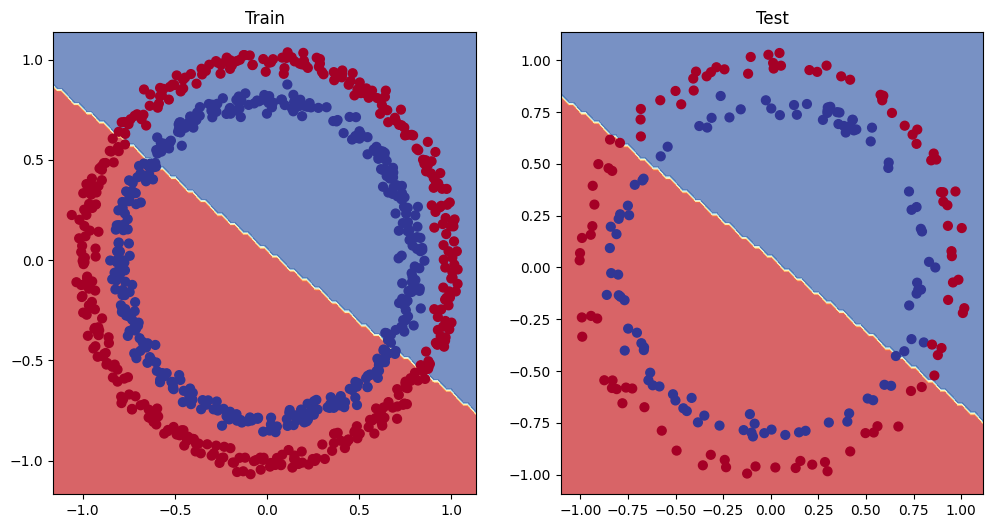

In [149]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # Row, Col, Index
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2) # Row, Col, Index
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model  (from a model perspective)
* **Add more layers** - Each layer potentially increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network deeper.

* **Add more hidden units** - Similar to the above, more hidden units per layer means a potential increase in learning capabilities of the model, more hidden units is often referred to as making your neural network wider.

* **Fitting for longer (more epochs)** - Your model might learn more if it had more opportunities to look at the data.

* **Changing the activation functions** - Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint).

* **Change the learning rate** - Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.

* **Change the loss function** - Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem.

* **Use transfer learning** - Take a pretrained model from a problem domain similar to yours and adjust it to your own problem.

These option is from model's perspective bcuz they deal directly with the model, rather than the data

Because we can tinker with these values they are referred to **hyperparameters**

In [150]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Creates 3 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
    self.layer_1 = nn.Linear(in_features=2, out_features=10) # layer_1 input (X) will take the shape of 2 output will be passed on layer_2,
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

    # 3. Defines a forward() method containing the forward pass computation of the model.
  def forward(self, x: torch.Tensor)-> torch.Tensor:
    z = self.layer_1(x)
    z = self.layer_2(z) # Overrides it and passed previous computation
    z = self.layer_3(z)
    return z
    #return self.layer_3(self.layer_2(self.layer_1(x))) # 2nd option

# 4. Instantiates the model class and sends it to the target device.
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [151]:
# setup loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = BCELoss with sigmoid activation function built-in, using BCELoss require to process input through sigmoid activation func manually

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1
                            )

In [152]:
torch.manual_seed(42) # optimizer step can be quite random depending on model prediction (y_pred)
torch.cuda.manual_seed(42)

# An epoch is one loop through the data (this is a hyperparameter)
epochs = 1000

# Track different values
epoch_count = []
loss_values = []
test_loss_values =[]


### Training (using training data)

#0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_1.train() # train mode in PyTorch sets all parameters that require gradients to require gradients


  #1. Forward propagation (also called forward pass)
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2. Calculate the loss / accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
  #                y_train)
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expect raw logits as inpur
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  #3. Optimizer zero gradient
  optimizer.zero_grad() # start fresh each iteration

  #4. Backpropagation (Loss backward)
  loss.backward()

  #5. Optimizer step (Gradient descent)
  # Optimizer step optimize the parameter so that we can reach the point of convergence (where loss = 0 (great prediction))
  optimizer.step() # by default how optimizer changes will accumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop
                  # may refer to the docs to understand why it accumulates

  ### Testing (using testing data)
  model_1.eval() # turns off different settings in the model not needing for testing
  with torch.inference_mode(): # turns off gradient tracking and couple more things behind the scenes
    #1. Forward propagation on test data
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #2. Calculate the test loss / Accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                    y_pred=test_pred)
  if epoch % 100 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc} | Test loss: {test_loss} | Test Accuracy: {test_acc}")


Epoch: 0 | Loss: 0.6939550638198853 | Accuracy: 50.875 | Test loss: 0.6926146149635315 | Test Accuracy: 51.0
Epoch: 100 | Loss: 0.6930477619171143 | Accuracy: 50.375 | Test loss: 0.6937903761863708 | Test Accuracy: 48.0
Epoch: 200 | Loss: 0.692986011505127 | Accuracy: 51.125 | Test loss: 0.6943727731704712 | Test Accuracy: 46.0
Epoch: 300 | Loss: 0.6929805278778076 | Accuracy: 51.625 | Test loss: 0.6945767998695374 | Test Accuracy: 45.0
Epoch: 400 | Loss: 0.6929798722267151 | Accuracy: 51.125 | Test loss: 0.6946452260017395 | Test Accuracy: 46.0
Epoch: 500 | Loss: 0.6929798722267151 | Accuracy: 51.0 | Test loss: 0.6946679949760437 | Test Accuracy: 46.0
Epoch: 600 | Loss: 0.6929798722267151 | Accuracy: 51.0 | Test loss: 0.6946756839752197 | Test Accuracy: 46.0
Epoch: 700 | Loss: 0.6929798722267151 | Accuracy: 51.0 | Test loss: 0.6946782469749451 | Test Accuracy: 46.0
Epoch: 800 | Loss: 0.6929798722267151 | Accuracy: 51.0 | Test loss: 0.6946792006492615 | Test Accuracy: 46.0
Epoch: 900 |

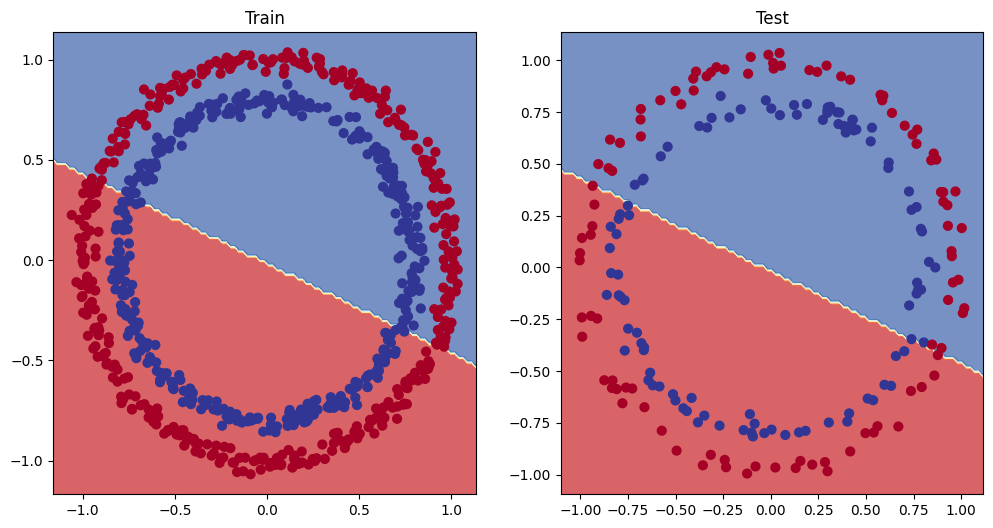

In [153]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # Row, Col, Index
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2) # Row, Col, Index
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6. The missing piece: non-linearity

### 6.1 Building a model with non-linearity

In [154]:
# Build a model with non-linear activation function
# 1. Construct a model that subclasses nn.Module
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Creates 3 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
    self.layer_1 = nn.Linear(in_features=2, out_features=10) # layer_1 input (X) will take the shape of 2 output will be passed on layer_2,
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a Non-linear activation function # LeakyReLU also work fine

    # 3. Defines a forward() method containing the forward pass computation of the model.
  def forward(self, x: torch.Tensor)-> torch.Tensor:
    z = self.relu(self.layer_1(x)) # uses the ReLU activation function
    z = self.relu(self.layer_2(z)) # Overrides it and passed previous computation
    z = self.layer_3(z)
    return z
    #return self.layer_3(self.layer_2(self.layer_1(x))) # 2nd option

# 4. Instantiates the model class and sends it to the target device.
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [155]:
# setup loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = BCELoss with sigmoid activation function built-in, using BCELoss require to process input through sigmoid activation func manually

optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01
                            )

In [158]:
torch.manual_seed(42) # optimizer step can be quite random depending on model prediction (y_pred)
torch.cuda.manual_seed(42)

# An epoch is one loop through the data (this is a hyperparameter)
epochs = 10000

# Track different values
epoch_count = []
loss_values = []
test_loss_values =[]


### Training (using training data)

#0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_2.train() # train mode in PyTorch sets all parameters that require gradients to require gradients


  #1. Forward propagation (also called forward pass)
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2. Calculate the loss / accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
  #                y_train)
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expect raw logits as inpur
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  #3. Optimizer zero gradient
  optimizer.zero_grad() # start fresh each iteration

  #4. Backpropagation (Loss backward)
  loss.backward()

  #5. Optimizer step (Gradient descent)
  # Optimizer step optimize the parameter so that we can reach the point of convergence (where loss = 0 (great prediction))
  optimizer.step() # by default how optimizer changes will accumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop
                  # may refer to the docs to understand why it accumulates

  ### Testing (using testing data)
  model_2.eval() # turns off different settings in the model not needing for testing
  with torch.inference_mode(): # turns off gradient tracking and couple more things behind the scenes
    #1. Forward propagation on test data
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #2. Calculate the test loss / Accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                    y_pred=test_pred)
  if epoch % 1000 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc} | Test loss: {test_loss} | Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 0.04171023890376091 | Accuracy: 99.875 | Test loss: 0.0658387765288353 | Test Accuracy: 100.0
Epoch: 1000 | Loss: 0.03624442592263222 | Accuracy: 99.875 | Test loss: 0.05977540463209152 | Test Accuracy: 100.0
Epoch: 2000 | Loss: 0.03202127665281296 | Accuracy: 99.875 | Test loss: 0.05460392311215401 | Test Accuracy: 100.0
Epoch: 3000 | Loss: 0.02869989164173603 | Accuracy: 99.875 | Test loss: 0.05023908242583275 | Test Accuracy: 100.0
Epoch: 4000 | Loss: 0.02602624148130417 | Accuracy: 99.875 | Test loss: 0.04662870243191719 | Test Accuracy: 100.0
Epoch: 5000 | Loss: 0.023819081485271454 | Accuracy: 99.875 | Test loss: 0.043633680790662766 | Test Accuracy: 100.0
Epoch: 6000 | Loss: 0.021945985034108162 | Accuracy: 99.875 | Test loss: 0.040904656052589417 | Test Accuracy: 100.0
Epoch: 7000 | Loss: 0.020351221784949303 | Accuracy: 99.875 | Test loss: 0.03863440081477165 | Test Accuracy: 100.0
Epoch: 8000 | Loss: 0.01897130161523819 | Accuracy: 99.875 | Test loss: 0.03681

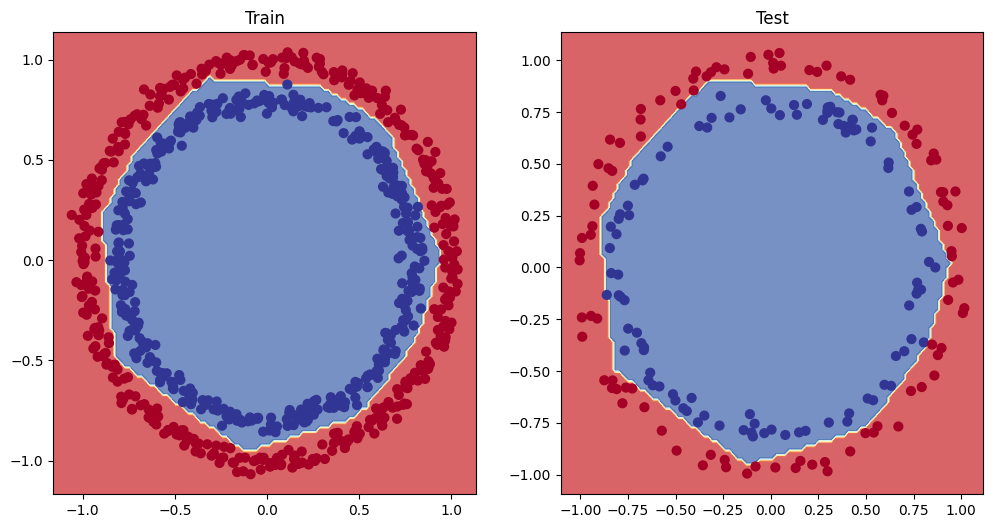

In [159]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # Row, Col, Index
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2) # Row, Col, Index
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

## 8. Building multi-linear classification

### 8.1 Create Blobs/Cluster data set

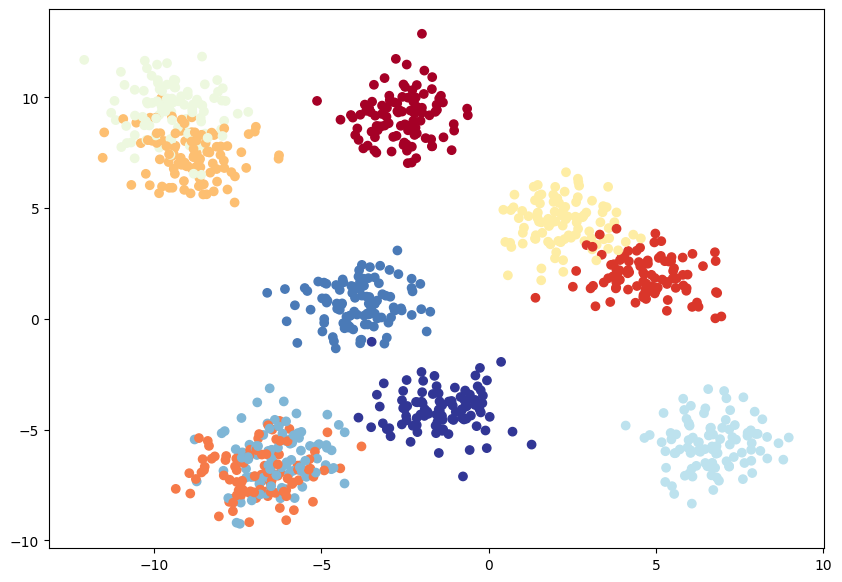

In [95]:
from sklearn.datasets import make_blobs

# Set the hyperparameters for data creation (usually in capital letters)
NUM_CLASSES = 10
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                    n_features=NUM_FEATURES,
                    centers=NUM_CLASSES,
                    cluster_std=1.0, # Give the clusters a bit of randomness
                    random_state=RANDOM_SEED
                    )

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED
                                                                        )

X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [96]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device, X_train.shape, X_blob_train.shape

('cpu', torch.Size([800, 2]), torch.Size([800, 2]))

In [97]:
# Build a multi-class classification model
# 1. Construct a model that subclasses nn.Module
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8): # Taking inputs #hidden_units is hyperparameter
    """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """


    super().__init__()

    # 2. Creates 3 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),# layer_1 input (X) will take the shape of 2 output will be passed on layer_2,
        nn.ReLU(), # ReLU for non-linearity
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(), # The model perform better if we add non-linear line into the equation
        nn.Linear(in_features=hidden_units, out_features=output_features)
     ) # We have 4 class so 4 out features


    # 3. Defines a forward() method containing the forward pass computation of the model.
  def forward(self, x: torch.Tensor)-> torch.Tensor:
    return self.linear_layer_stack(x) # pass the input x, don't forget!
    #return self.layer_3(self.layer_2(self.layer_1(x))) # 2nd option

# 4. Instantiates the model class and sends it to the target device.
model_blob = BlobModel(input_features=2, output_features=10, hidden_units=20).to(device)
model_blob

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)

### 8.3 Create loss function and optimizer

In [98]:
# setup loss function
loss_fn = nn.CrossEntropyLoss() # Cross Entropy Loss for multi-class classification
                                # params weight can be utilized to deal with imbalanced dataset, in our our data is balanced so not really necessary

optimizer = torch.optim.SGD(params=model_blob.parameters(),
                            lr=0.1 # learning rate is hyperparameter
                            )

Same principle, logits -> prediction probabilities -> prediction labels

In [99]:
model_blob.eval()
with torch.inference_mode():
  y_logits = model_blob(X_blob_train).squeeze()

# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(sum(y_pred_probs[0])) # Sum of each array is 1 bcuz of softmax activation
y_logits[:5], y_pred_probs[:5], torch.argmax(y_pred_probs, dim=1)

tensor(1.0000)


(tensor([[ 0.0557,  0.2656,  0.5453,  0.9791, -1.1995,  0.1969,  0.1363, -0.5185,
           0.4782,  0.1411],
         [ 0.3923, -0.5386,  0.1311,  0.3929, -0.1849, -0.1613, -0.2006, -0.1268,
          -0.0068,  0.1044],
         [-0.0420,  0.4788, -0.0048,  0.6097, -0.8837,  0.1882, -0.4847, -0.4118,
          -0.3919,  0.2186],
         [ 1.2288, -0.4791,  0.1107,  0.4848, -0.5422, -0.5464, -0.0166, -1.3408,
          -0.1046,  0.0225],
         [ 0.0049,  0.0933, -0.2355,  0.3526, -0.6043,  0.0347, -0.2631, -0.4463,
           0.1030,  0.1169]]),
 tensor([[0.0828, 0.1021, 0.1351, 0.2084, 0.0236, 0.0953, 0.0897, 0.0466, 0.1263,
          0.0901],
         [0.1456, 0.0574, 0.1121, 0.1456, 0.0817, 0.0837, 0.0805, 0.0866, 0.0977,
          0.1091],
         [0.0938, 0.1578, 0.0973, 0.1799, 0.0404, 0.1180, 0.0602, 0.0648, 0.0661,
          0.1217],
         [0.3077, 0.0558, 0.1006, 0.1462, 0.0524, 0.0521, 0.0886, 0.0236, 0.0811,
          0.0921],
         [0.1054, 0.1151, 0.0828, 0.149

### 8.4 Create Training and testing loop



In [100]:
(model_blob(X_blob_train).squeeze()).shape, y_blob_train.type(torch.LongTensor).to(device).shape

(torch.Size([800, 10]), torch.Size([800]))

In [122]:
torch.manual_seed(42) # optimizer step can be quite random depending on model prediction (y_pred)
torch.cuda.manual_seed(42)

# An epoch is one loop through the data (this is a hyperparameter)
epochs = 10000

# Track different values
epoch_count = []
loss_values = []
test_loss_values =[]


### Training (using training data)

#0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_blob.train() # train mode in PyTorch sets all parameters that require gradients to require gradients


  #1. Forward propagation (also called forward pass)
  y_logits = model_blob(X_blob_train).squeeze()
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  #2. Calculate the loss / accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
  #                y_train)
  loss = loss_fn(y_logits, y_blob_train.type(torch.LongTensor).to(device)) # nn.BCEWithLogitsLoss expect raw logits as inpur
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  #3. Optimizer zero gradient
  optimizer.zero_grad() # start fresh each iteration

  #4. Backpropagation (Loss backward)
  loss.backward()

  #5. Optimizer step (Gradient descent)
  # Optimizer step optimize the parameter so that we can reach the point of convergence (where loss = 0 (great prediction))
  optimizer.step() # by default how optimizer changes will accumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop
                  # may refer to the docs to understand why it accumulates

  ### Testing (using testing data)
  model_blob.eval() # turns off different settings in the model not needing for testing
  with torch.inference_mode(): # turns off gradient tracking and couple more things behind the scenes
    #1. Forward propagation on test data
    test_logits = model_blob(X_blob_test).squeeze()
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    #2. Calculate the test loss / Accuracy
    test_loss = loss_fn(test_logits, y_blob_test.type(torch.LongTensor).to(device))
    test_acc = accuracy_fn(y_true=y_blob_test,
                    y_pred=test_pred)
  if epoch % 1000 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc} | Test loss: {test_loss} | Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 0.21913529932498932 | Accuracy: 88.75 | Test loss: 0.22178688645362854 | Test Accuracy: 88.0
Epoch: 1000 | Loss: 0.21913529932498932 | Accuracy: 88.75 | Test loss: 0.22178688645362854 | Test Accuracy: 88.0
Epoch: 2000 | Loss: 0.21913529932498932 | Accuracy: 88.75 | Test loss: 0.22178688645362854 | Test Accuracy: 88.0
Epoch: 3000 | Loss: 0.21913529932498932 | Accuracy: 88.75 | Test loss: 0.22178688645362854 | Test Accuracy: 88.0
Epoch: 4000 | Loss: 0.21913529932498932 | Accuracy: 88.75 | Test loss: 0.22178688645362854 | Test Accuracy: 88.0
Epoch: 5000 | Loss: 0.21913529932498932 | Accuracy: 88.75 | Test loss: 0.22178688645362854 | Test Accuracy: 88.0
Epoch: 6000 | Loss: 0.21913529932498932 | Accuracy: 88.75 | Test loss: 0.22178688645362854 | Test Accuracy: 88.0
Epoch: 7000 | Loss: 0.21913529932498932 | Accuracy: 88.75 | Test loss: 0.22178688645362854 | Test Accuracy: 88.0
Epoch: 8000 | Loss: 0.21913529932498932 | Accuracy: 88.75 | Test loss: 0.22178688645362854 | Test A

88.0


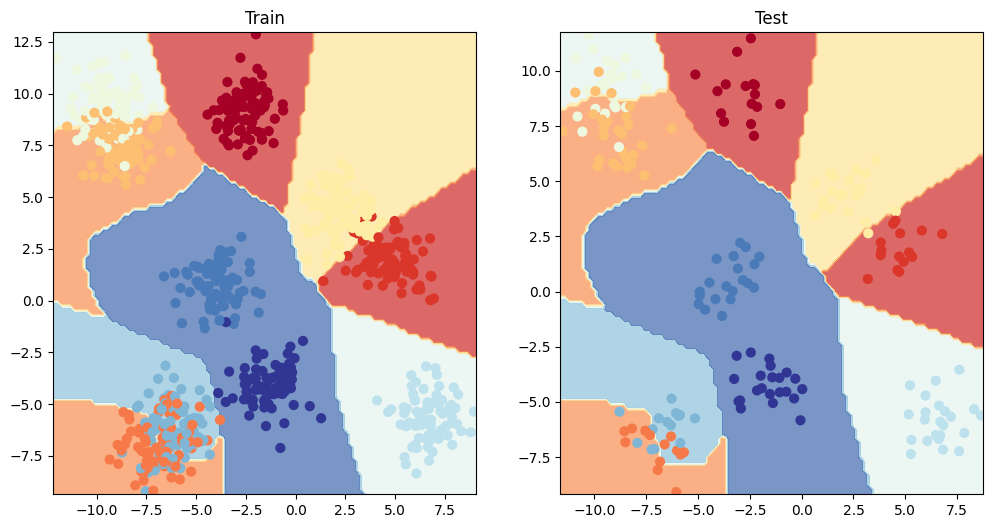

In [102]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # Row, Col, Index
plt.title("Train")
plot_decision_boundary(model_blob, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2) # Row, Col, Index
plt.title("Test")
plot_decision_boundary(model_blob, X_blob_test, y_blob_test)
print(acc)

## 9. Other classification evaluation metrics

* Accuracy - Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. using  `torchmetrics.Accuracy()` or `sklearn.metrics.accuracy_score()`

* Precision - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). using `torchmetrics.Precision()` or `sklearn.metrics.precision_score()`

* Recall - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. using `torchmetrics.Recall()` or `sklearn.metrics.recall_score()`

* F1-score - 	Combines precision and recall into one metric. 1 is best, 0 is worst. using `torchmetrics.F1Score()` or `sklearn.metrics.f1_score()`

* Confusion matrix - Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). using `torchmetrics.ConfusionMatrix` or `sklearn.metrics.plot_confusion_matrix()`

* Classification report - Collection of some of the main classification metrics such as precision, recall and f1-score. using `sklearn.metrics.classification_report()`

# 10. Exercise

## 10.1 Moons (Binary Classification)

In [103]:
import torch
from torch import nn # nn contains all of building blocks of neural networks from torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn # great for machine learning purposes
from sklearn.datasets import make_moons

In [104]:
device_exercise = "cuda" if torch.cuda.is_available() else "cpu"
device_exercise

'cpu'

In [105]:
# Make 1000 samples
n_samples = 1000

# Create circles
X_exercise, y_exercise = make_moons(n_samples,
                    noise=0.03, # put a bit of randomness
                    random_state=42 # equivalent of seed
                    )

# 2. Turn data into tensors
X_exercise = torch.from_numpy(X_exercise).type(torch.float)
y_exercise = torch.from_numpy(y_exercise).type(torch.float)
X_exercise.shape

torch.Size([1000, 2])

tensor([[ 0.5172, -0.3785],
        [ 0.7536,  0.6871],
        [ 1.2408, -0.4597],
        [ 0.6236,  0.8408],
        [ 1.8526, -0.0454]])


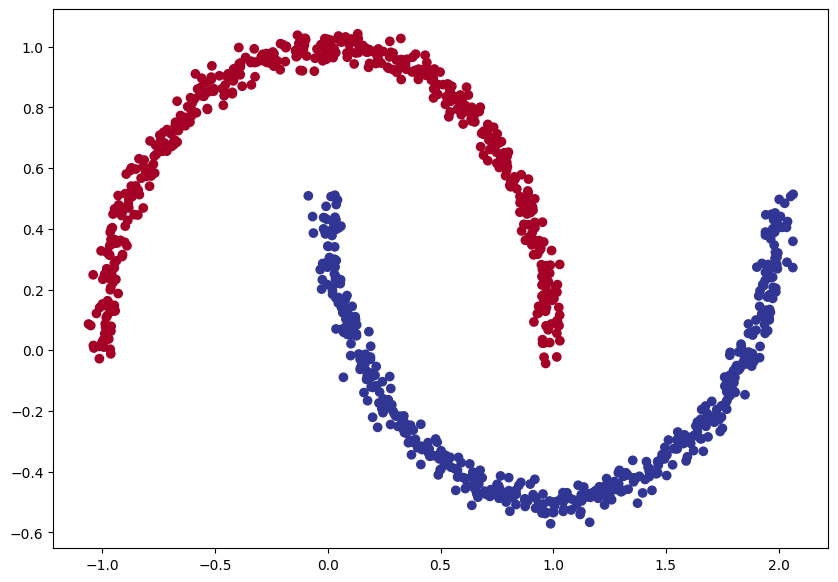

In [106]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train_exercise, X_test_exercise, y_train_exercise, y_test_exercise = train_test_split(X_exercise,
                                                    y_exercise,
                                                    test_size=0.2, # 20% of data will be test & 80% will be train
                                                    random_state=42 # train_test_split split the data randomly, for reproducibility use random_state (seed)
                                                    )

X_train_exercise, X_test_exercise, y_train_exercise, y_test_exercise = X_train_exercise.to(device), X_test_exercise.to(device), y_train_exercise.to(device), y_test_exercise.to(device)
plt.figure(figsize=(10,7))
plt.scatter(X_exercise[:, 0], X_exercise[:, 1], c=y_exercise, cmap=plt.cm.RdYlBu)
print(X_test_exercise[:5])

In [107]:
# Build a binary classification model
# 1. Construct a model that subclasses nn.Module
class MoonModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8): # Taking inputs #hidden_units is hyperparameter
    """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """


    super().__init__()

    # 2. Creates 3 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),# layer_1 input (X) will take the shape of 2 output will be passed on layer_2,
        nn.ReLU(), # ReLU for non-linearity
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(), # The model perform better if we add non-linear line into the equation
        nn.Linear(in_features=hidden_units, out_features=output_features)
     ) # Because this is binary classifiation out features will only be one


    # 3. Defines a forward() method containing the forward pass computation of the model.
  def forward(self, x: torch.Tensor)-> torch.Tensor:
    return self.linear_layer_stack(x) # pass the input x, don't forget!
    #return self.layer_3(self.layer_2(self.layer_1(x))) # 2nd option

# 4. Instantiates the model class and sends it to the target device.
model_moon = MoonModel(input_features=2, output_features=1, hidden_units=8).to(device)
model_moon

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [108]:
model_moon(X_test_exercise).squeeze()[:5], (torch.sign(model_moon(X_test_exercise).squeeze()[:5])), y_train_exercise[:5]

(tensor([-0.0971, -0.2020, -0.1853, -0.1810, -0.3208], grad_fn=<SliceBackward0>),
 tensor([-1., -1., -1., -1., -1.], grad_fn=<SignBackward0>),
 tensor([1., 0., 0., 0., 1.]))

In [109]:
# setup loss function
loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(params=model_moon.parameters(),
                            lr=0.1 # learning rate is hyperparameter
                            )

In [110]:
torch.manual_seed(42) # optimizer step can be quite random depending on model prediction (y_pred)
torch.cuda.manual_seed(42)

# An epoch is one loop through the data (this is a hyperparameter)
epochs = 10000

# Track different values
epoch_count = []
loss_values = []
test_loss_values =[]


### Training (using training data)

#0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_moon.train() # train mode in PyTorch sets all parameters that require gradients to require gradients


  #1. Forward propagation (also called forward pass)
  y_logits = model_moon(X_train_exercise).squeeze()
  y_pred = (y_logits)

  #2. Calculate the loss / accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
  #                y_train)
  loss = loss_fn(torch.sigmoid(torch.tanh(y_logits)),y_train_exercise) # nn.BCEWithLogitsLoss expect raw logits as inpur
  acc = accuracy_fn(y_true=y_train_exercise,
                    y_pred=torch.relu(torch.sign(y_pred)))

  #3. Optimizer zero gradient
  optimizer.zero_grad() # start fresh each iteration

  #4. Backpropagation (Loss backward)
  loss.backward()

  #5. Optimizer step (Gradient descent)
  # Optimizer step optimize the parameter so that we can reach the point of convergence (where loss = 0 (great prediction))
  optimizer.step() # by default how optimizer changes will accumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop
                  # may refer to the docs to understand why it accumulates

  ### Testing (using testing data)
  model_moon.eval() # turns off different settings in the model not needing for testing
  with torch.inference_mode(): # turns off gradient tracking and couple more things behind the scenes
    #1. Forward propagation on test data
    test_logits = model_moon(X_test_exercise).squeeze()
    test_pred = torch.tanh(test_logits)#.argmax(dim=1)
    #2. Calculate the test loss / Accuracy
    test_loss = loss_fn(torch.sigmoid(torch.tanh(test_logits)), y_test_exercise)
    test_acc = accuracy_fn(y_true=y_test_exercise,
                    y_pred=torch.relu(torch.sign(test_pred)))
  if epoch % 1000 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc} | Test loss: {test_loss} | Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 0.7109308838844299 | Accuracy: 50.0 | Test loss: 0.7050930857658386 | Test Accuracy: 50.0
Epoch: 1000 | Loss: 0.3396604657173157 | Accuracy: 99.375 | Test loss: 0.3372134864330292 | Test Accuracy: 100.0
Epoch: 2000 | Loss: 0.3166878819465637 | Accuracy: 100.0 | Test loss: 0.31601884961128235 | Test Accuracy: 100.0
Epoch: 3000 | Loss: 0.314840167760849 | Accuracy: 100.0 | Test loss: 0.31448307633399963 | Test Accuracy: 100.0
Epoch: 4000 | Loss: 0.3142456114292145 | Accuracy: 100.0 | Test loss: 0.314008891582489 | Test Accuracy: 100.0
Epoch: 5000 | Loss: 0.31396257877349854 | Accuracy: 100.0 | Test loss: 0.3137865662574768 | Test Accuracy: 100.0
Epoch: 6000 | Loss: 0.31379973888397217 | Accuracy: 100.0 | Test loss: 0.3136606812477112 | Test Accuracy: 100.0
Epoch: 7000 | Loss: 0.3136950433254242 | Accuracy: 100.0 | Test loss: 0.3135802447795868 | Test Accuracy: 100.0
Epoch: 8000 | Loss: 0.31362250447273254 | Accuracy: 100.0 | Test loss: 0.3135249614715576 | Test Accuracy:

100.0


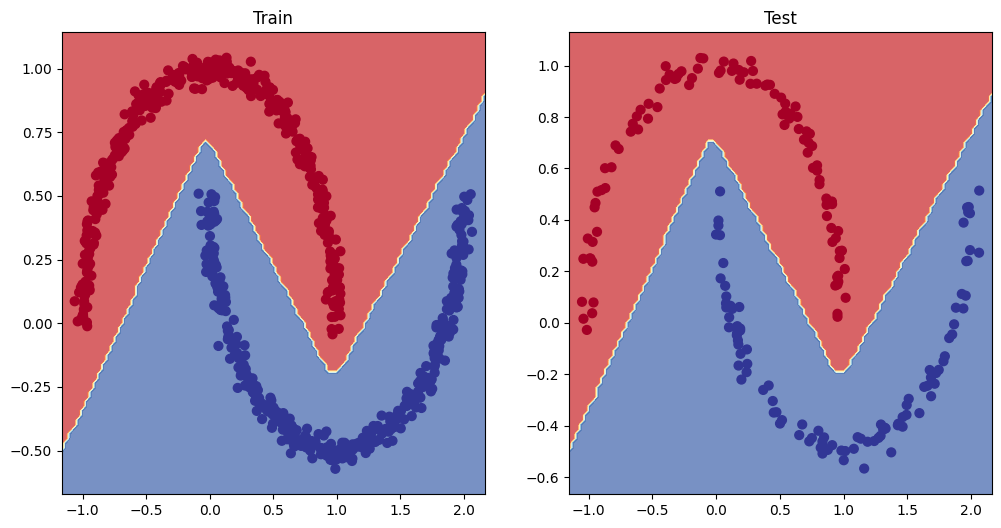

In [111]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # Row, Col, Index
plt.title("Train")
plot_decision_boundary(model_moon, X_train_exercise, y_train_exercise)
plt.subplot(1, 2, 2) # Row, Col, Index
plt.title("Test")
plot_decision_boundary(model_moon, X_test_exercise, y_test_exercise)
print(acc)

## 10.2 Spiral (Multi-Class Classification)

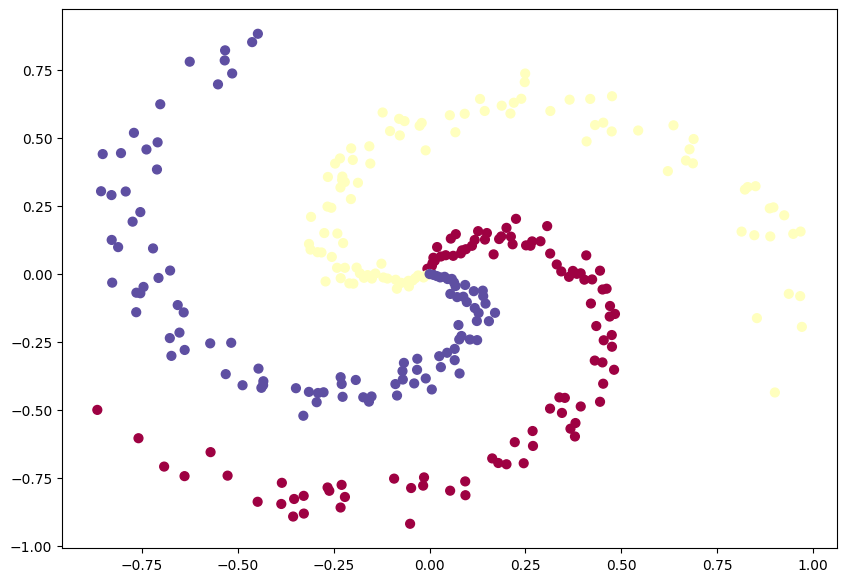

[[ 0.          0.        ]
 [ 0.00218155  0.00986262]
 [-0.0057892   0.01935476]
 [ 0.00597057  0.02970902]
 [ 0.00755143  0.0396921 ]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2] <class 'numpy.ndarray'>


In [112]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X_spiral = np.zeros((N*K,D)) # data matrix (each row = single example)
y_spiral = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X_spiral[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y_spiral[ix] = j
# lets visualize the data
plt.figure(figsize=(10,7))
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], c=y_spiral, s=40, cmap=plt.cm.Spectral)
plt.show()
print(X_spiral[:5], y_spiral[:], type(X_spiral))

In [113]:
# Turn data into tensors
X_spiral = torch.from_numpy(X_spiral).type(torch.float)
y_spiral = torch.from_numpy(y_spiral).type(torch.float)
X_spiral.shape

torch.Size([300, 2])

tensor([[ 0.0276, -0.0124],
        [-0.6568, -0.1141],
        [ 0.0672,  0.5209],
        [ 0.0616,  0.0669],
        [-0.0670, -0.3265]])


<ipython-input-114-92c42e7b9715>:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  plt.scatter(X_spiral[:, 0], X_spiral[:, 1], c=y_spiral.T, cmap=plt.cm.RdYlBu)


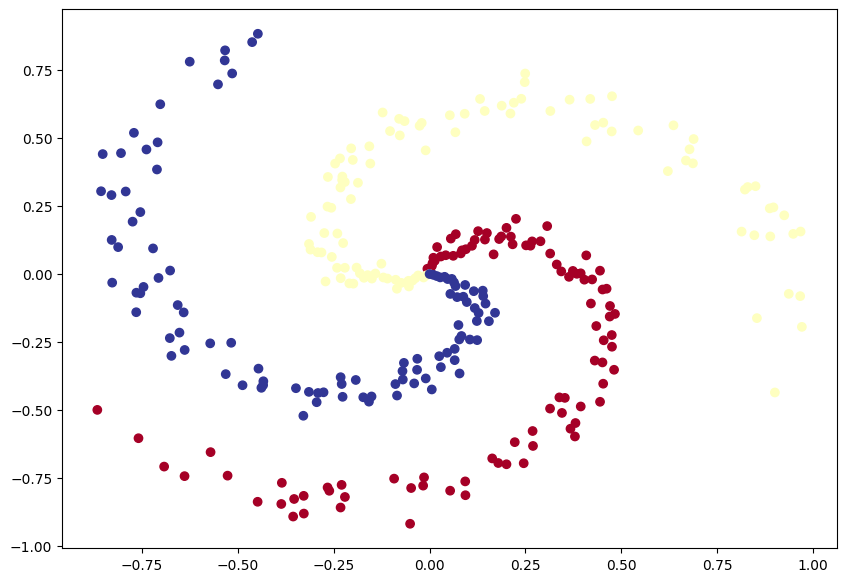

In [114]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train_spiral, X_test_spiral, y_train_spiral, y_test_spiral = train_test_split(X_spiral,
                                                    y_spiral,
                                                    test_size=0.2, # 20% of data will be test & 80% will be train
                                                    random_state=42 # train_test_split split the data randomly, for reproducibility use random_state (seed)
                                                    )

X_train_spiral, X_test_spiral, y_train_spiral, y_test_spiral = X_train_spiral.to(device), X_test_spiral.to(device), y_train_spiral.to(device), y_test_spiral.to(device)
plt.figure(figsize=(10,7))
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], c=y_spiral.T, cmap=plt.cm.RdYlBu)
print(X_test_spiral[:5])

In [115]:
# Build a binary classification model
# 1. Construct a model that subclasses nn.Module
class SpiralModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8): # Taking inputs #hidden_units is hyperparameter
    """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """


    super().__init__()

    # 2. Creates 3 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),# layer_1 input (X) will take the shape of 2 output will be passed on layer_2,
        nn.ReLU(), # ReLU for non-linearity
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(), # The model perform better if we add non-linear line into the equation
        nn.Linear(in_features=hidden_units, out_features=output_features)
     ) # Because this is binary classifiation out features will only be one


    # 3. Defines a forward() method containing the forward pass computation of the model.
  def forward(self, x: torch.Tensor)-> torch.Tensor:
    return self.linear_layer_stack(x) # pass the input x, don't forget!
    #return self.layer_3(self.layer_2(self.layer_1(x))) # 2nd option

# 4. Instantiates the model class and sends it to the target device.
model_spiral = SpiralModel(input_features=2, output_features=3, hidden_units=16).to(device)
model_spiral

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [116]:
# setup loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_spiral.parameters(),
                            lr=0.1 # learning rate is hyperparameter
                            )

In [120]:
torch.manual_seed(42) # optimizer step can be quite random depending on model prediction (y_pred)
torch.cuda.manual_seed(42)

# An epoch is one loop through the data (this is a hyperparameter)
epochs = 100000

# Track different values
epoch_count = []
loss_values = []
test_loss_values =[]


### Training (using training data)

#0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_spiral.train() # train mode in PyTorch sets all parameters that require gradients to require gradients


  #1. Forward propagation (also called forward pass)
  y_logits = model_spiral(X_train_spiral).squeeze()
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  #2. Calculate the loss / accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
  #                y_train)
  loss = loss_fn(torch.sigmoid(torch.tanh(y_logits)), y_train_spiral.type(torch.LongTensor).to(device)) # nn.BCEWithLogitsLoss expect raw logits as inpur
  acc = accuracy_fn(y_true=y_train_spiral,
                    y_pred=y_pred)

  #3. Optimizer zero gradient
  optimizer.zero_grad() # start fresh each iteration

  #4. Backpropagation (Loss backward)
  loss.backward()

  #5. Optimizer step (Gradient descent)
  # Optimizer step optimize the parameter so that we can reach the point of convergence (where loss = 0 (great prediction))
  optimizer.step() # by default how optimizer changes will accumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop
                  # may refer to the docs to understand why it accumulates

  ### Testing (using testing data)
  model_spiral.eval() # turns off different settings in the model not needing for testing
  with torch.inference_mode(): # turns off gradient tracking and couple more things behind the scenes
    #1. Forward propagation on test data
    test_logits = model_spiral(X_test_spiral).squeeze()
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    #2. Calculate the test loss / Accuracy
    test_loss = loss_fn(torch.sigmoid(torch.tanh(test_logits)), y_test_spiral.type(torch.LongTensor).to(device))
    test_acc = accuracy_fn(y_true=y_test_spiral,
                    y_pred=test_pred)
  if epoch % 10000 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc} | Test loss: {test_loss} | Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 0.8830551505088806 | Accuracy: 72.5 | Test loss: 0.896254301071167 | Test Accuracy: 66.66666666666666
Epoch: 10000 | Loss: 0.8759555220603943 | Accuracy: 73.33333333333333 | Test loss: 0.8886602520942688 | Test Accuracy: 71.66666666666667
Epoch: 20000 | Loss: 0.8407039046287537 | Accuracy: 90.83333333333333 | Test loss: 0.8415765166282654 | Test Accuracy: 93.33333333333333
Epoch: 30000 | Loss: 0.8271233439445496 | Accuracy: 97.5 | Test loss: 0.8217385411262512 | Test Accuracy: 100.0
Epoch: 40000 | Loss: 0.8242110013961792 | Accuracy: 98.33333333333333 | Test loss: 0.8194930553436279 | Test Accuracy: 100.0
Epoch: 50000 | Loss: 0.821968138217926 | Accuracy: 98.75 | Test loss: 0.8158188462257385 | Test Accuracy: 100.0
Epoch: 60000 | Loss: 0.8209158182144165 | Accuracy: 99.16666666666667 | Test loss: 0.8156093955039978 | Test Accuracy: 100.0
Epoch: 70000 | Loss: 0.8199172616004944 | Accuracy: 99.16666666666667 | Test loss: 0.8155151605606079 | Test Accuracy: 100.0
Epoch: 8

In [118]:
y_test_spiral.shape, torch.softmax(y_logits, dim=1).argmax(dim=1).shape

(torch.Size([60]), torch.Size([240]))

99.16666666666667


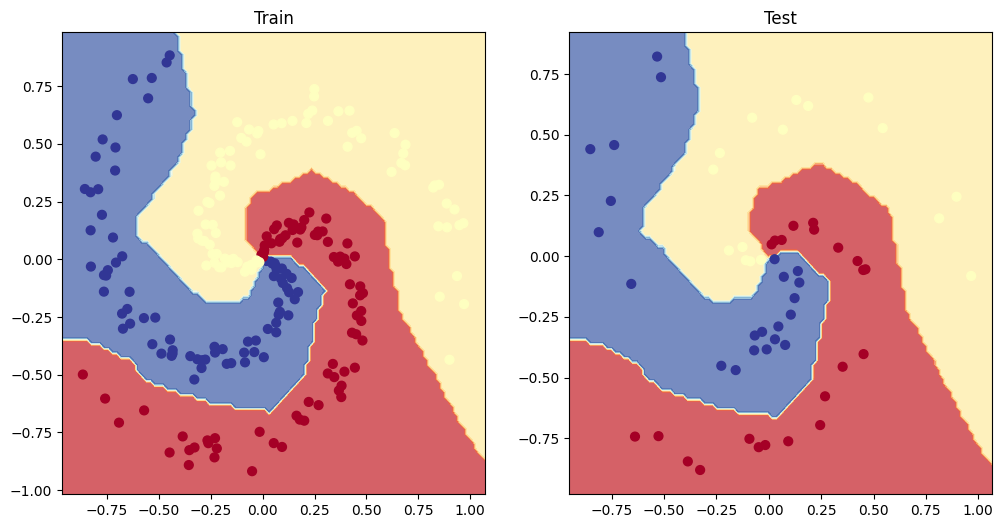

In [121]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # Row, Col, Index
plt.title("Train")
plot_decision_boundary(model_spiral, X_train_spiral, y_train_spiral)
plt.subplot(1, 2, 2) # Row, Col, Index
plt.title("Test")
plot_decision_boundary(model_spiral, X_test_spiral, y_test_spiral)
print(acc)